Восстановление изображений с помощью автокодировщика на базе картинок MINST.

## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [ ]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Reshape

# Оптимизатор
from tensorflow.keras.optimizers import Adam

import random
import copy

## Данные

In [ ]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

## Автокодировщик

In [ ]:
###################################################################
###                 МЕСТО ДЛЯ ВАШЕГО ТВОРЧЕСТВА              ###
###################################################################

Добавим квадраты на изображения

In [ ]:
SquareSide=8
x_pos_train=[random.randint(0,X_train.shape[1]-SquareSide) for i in range(X_train.shape[0])]
y_pos_train=[random.randint(0,X_train.shape[2]-SquareSide) for i in range(X_train.shape[0])]
x_pos_test=[random.randint(0,X_test.shape[1]-SquareSide) for i in range(X_test.shape[0])]
y_pos_test=[random.randint(0,X_test.shape[2]-SquareSide) for i in range(X_test.shape[0])]
blackSquare=np.zeros((SquareSide,SquareSide))

X_train_square = copy.copy(X_train)
X_test_square = copy.copy(X_test)


for i in range(X_train_square.shape[0]):
  X_train_square[i,x_pos_train[i]:x_pos_train[i]+SquareSide,y_pos_train[i]:y_pos_train[i]+SquareSide,0]=blackSquare
for i in range(X_test_square.shape[0]):
  X_test_square[i,x_pos_test[i]:x_pos_test[i]+SquareSide,y_pos_test[i]:y_pos_test[i]+SquareSide,0]=blackSquare


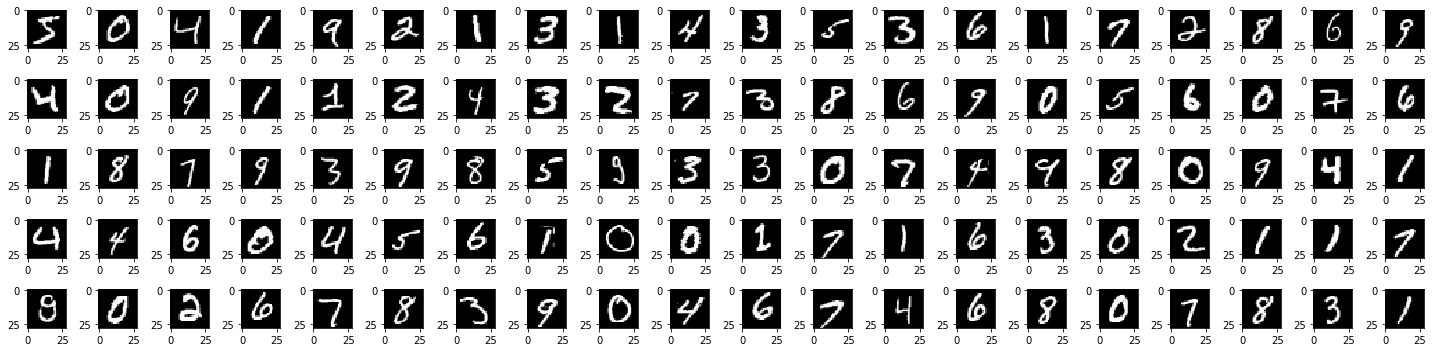

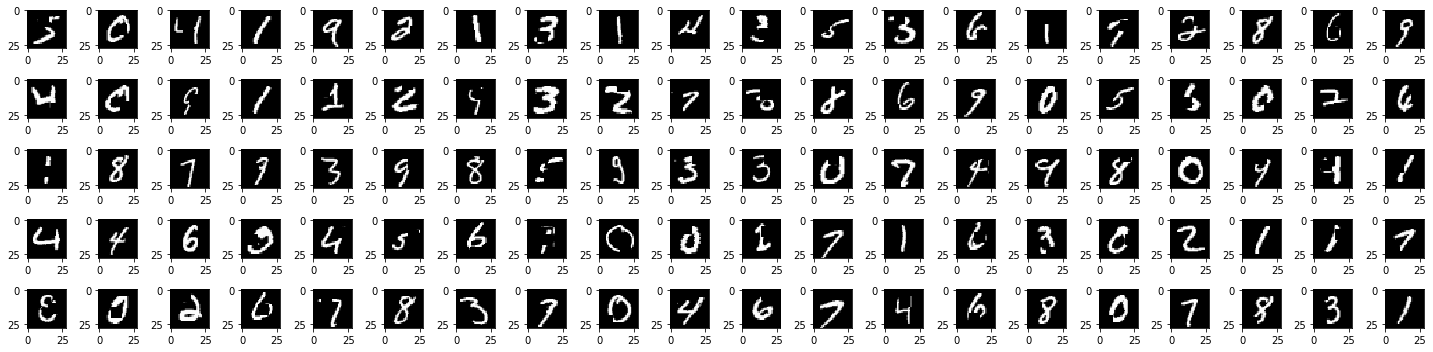

In [ ]:
print("без квадратов")
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(X_train[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()
print()
print("с квадратами")
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(X_train_square[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()

Создание и обучение модели

In [ ]:
epochs=100
SHAPE=X_train[0].shape
inputs = Input(SHAPE)
pre_flat_shape=inputs.shape[1:]
flat_shape=pre_flat_shape[0]*pre_flat_shape[1]*pre_flat_shape[2]
print(pre_flat_shape,flat_shape)
x=Conv2D(32,3, activation='relu')(inputs)
print(x.shape)
x=MaxPooling2D()(x)
print(x.shape)
x=Conv2D(64,4, activation='relu')(x)
print(x.shape)
x=MaxPooling2D()(x)
print(x.shape)
x=Conv2D(8,3, activation='relu')(x)
print(x.shape)
BeforeFlattenShape=x.shape[1:]
x=Flatten()(x)
FlattenShape=x.shape[1:]
print(x.shape)
#x=Dense(100, activation='relu')(x)
encoded = BatchNormalization()(x)

input_encoded = Input(shape=FlattenShape)

x=Reshape(BeforeFlattenShape)(input_encoded)
print(x.shape)
x=Conv2DTranspose(64,3, activation='relu')(x)
print(x.shape)
x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
print(x.shape)
x = Conv2DTranspose(32, 4, activation='relu')(x)
print(x.shape)
x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
print(x.shape)
x = Conv2DTranspose(16, 3, activation='relu')(x)
print(x.shape)
x = Conv2DTranspose(1, 1, activation='relu')(x)
print(x.shape)

#x=Conv2DTranspose(128,4, activation='relu')(x)
#x=Dense(1000, activation='relu')(x)
#x=Dense(flat_shape, activation='relu')(x)
outputs=x#Reshape(pre_flat_shape)(x)

encoder = Model(inputs, encoded, name='encoder')
print()
decoder = Model(input_encoded, outputs, name='decoder')
print()
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")


#model=Model(inputs=inputs, outputs=outputs)
autoencoder.compile(loss='mean_squared_error',optimizer=Adam(0.001),metrics=['accuracy'])
encoder.summary()
decoder.summary()
autoencoder.summary()

#TrainSize=int(X_train.shape[0]*0.9)

history = autoencoder.fit(X_train_square,X_train,validation_data=(X_test_square,X_test),epochs=epochs, batch_size=128)

(28, 28, 1) 784
(None, 26, 26, 32)
(None, 13, 13, 32)
(None, 10, 10, 64)
(None, 5, 5, 64)
(None, 3, 3, 8)
(None, 72)
(None, 3, 3, 8)
(None, 5, 5, 64)
(None, 10, 10, 64)
(None, 13, 13, 32)
(None, 26, 26, 32)
(None, 28, 28, 16)
(None, 28, 28, 1)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        32832     
                                                                 
 max_poolin

Проверка на тренировочной выборке

тренировочная с квадратами


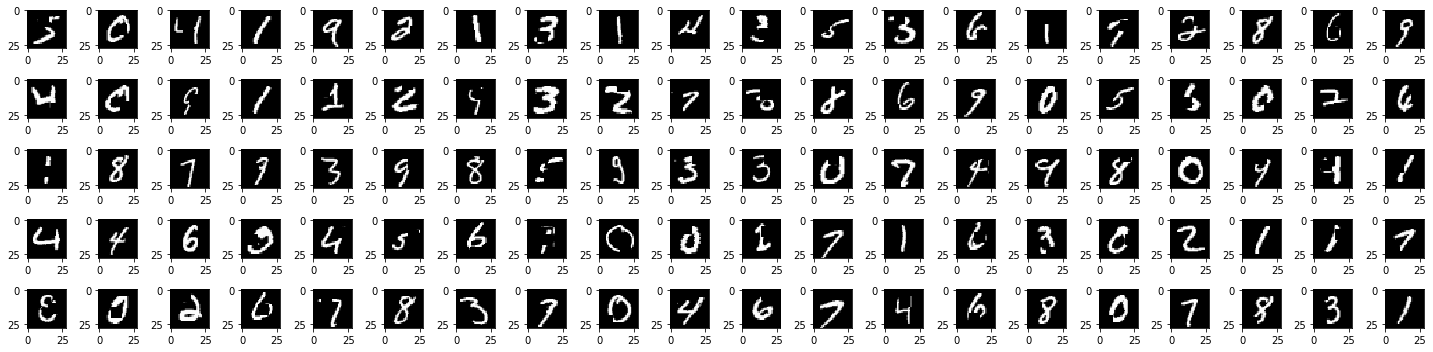


тренировочная восстановленная


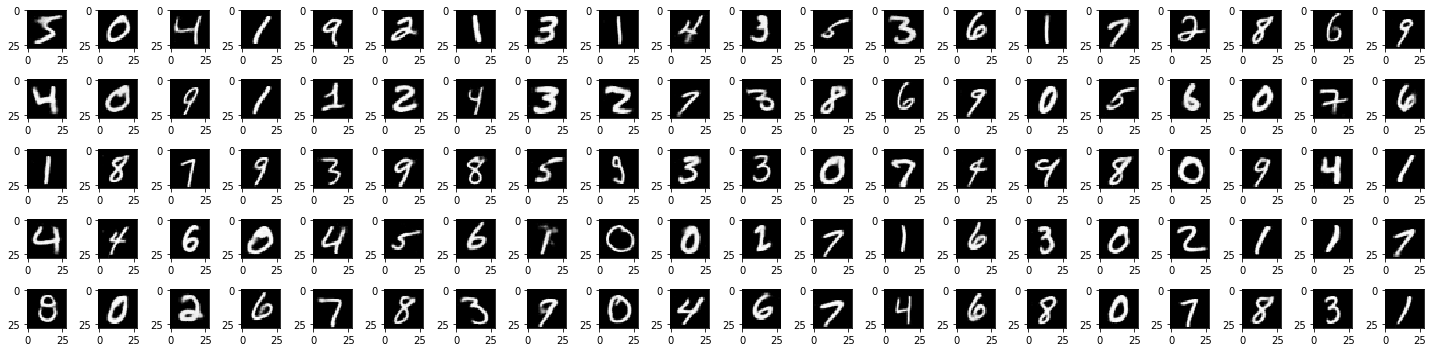

In [ ]:
print("тренировочная с квадратами")
predict_train=autoencoder.predict(X_train_square[:100])
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(X_train_square[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()
print()
print("тренировочная восстановленная")
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(predict_train[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()

Проверка на трестовой выборке

тестовая с квадратами


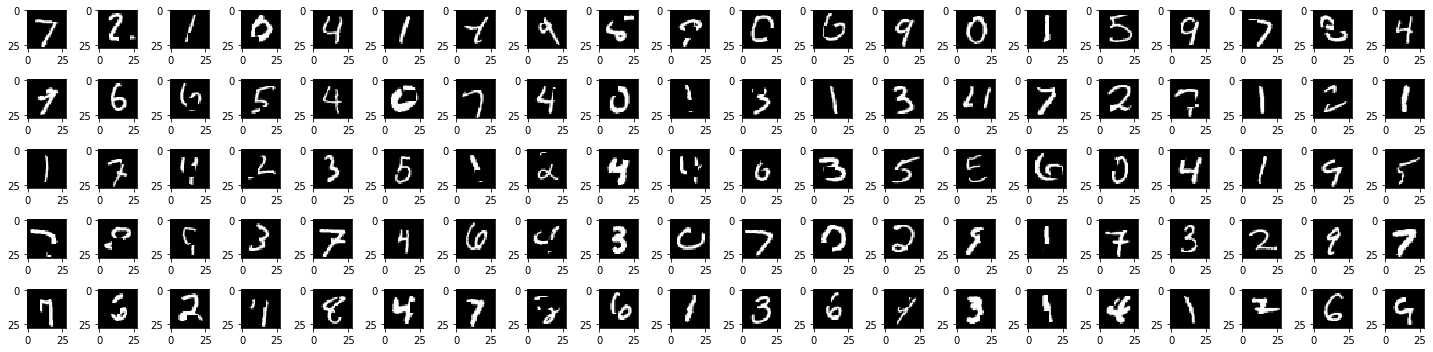


тестовая восстановленная


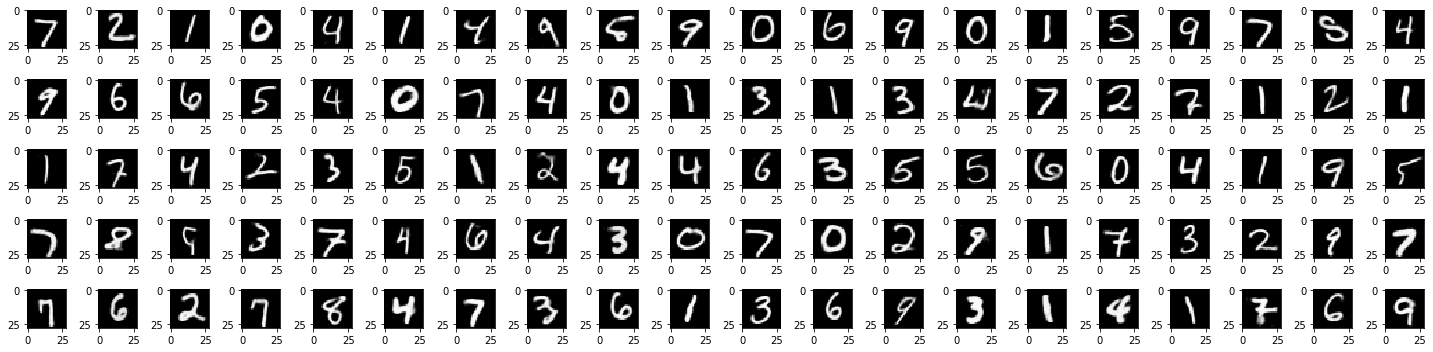

In [ ]:
print("тестовая с квадратами")
predict_test=autoencoder.predict(X_test_square[:100])
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(X_test_square[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()
print()
print("тестовая восстановленная")
fig, ax = plt.subplots(5,20,figsize=(20,5))
for index in range(100):
  c1=ax[int(index/20),int(index%20)].imshow(predict_test[index].reshape(28,28),cmap='gray', interpolation='nearest')
plt.tight_layout()
plt.show()

Восстанавливает очень хорошо и тренировочную и тестовую